In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

#All these packages need to be installed from pip

#This will be doing most of the work
import networkx as nx

import nltk #For POS tagging
import sklearn #For generating some matrices
import pandas as pd#For DataFrames
import numpy as np #For arrays
import matplotlib.pyplot as plt #For plotting
import seaborn #MAkes the plots look nice

import pickle #if you want to save layouts
import os

%matplotlib inline

D:\computation\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
import pandas
powMIA95 = pandas.read_csv('D:/contentAnalysis/vietnam/powMIA_95.csv')

In [3]:
powMIA95['tokenized_sents'] = powMIA95['article'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
powMIA95['normalized_sents'] = powMIA95['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s, stopwordLst = None, stemmer = lucem_illud.stemmer_basic) for s in x])

In [4]:
pow80 = powMIA95[powMIA95['date'].str.contains('1980|1981|1982|1983|1984', na = False)]
pow85 = powMIA95[powMIA95['date'].str.contains('1985|1986|1987|1988|1989', na = False)]
pow90 = powMIA95[powMIA95['date'].str.contains('1990|1991|1992|1993|1994|1995', na = False)]


In [5]:
print(len(pow80))
print(len(pow85))
print(len(pow90))

58
93
205


## The whole thang

In [6]:
def wordCooccurrence(sentences, makeMatrix = False):
    words = set()
    for sent in sentences:
        words |= set(sent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in sentences:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        return g

In [187]:
g = wordCooccurrence(powMIA95['normalized_sents'].sum())

In [182]:
def tokenize(text):
    tokenlist = nltk.word_tokenize(text)
    normalized = lucem_illud.normalizeTokens(tokenlist, stopwordLst = lucem_illud.stop_words_basic, stemmer = lucem_illud.stemmer_basic)
    return normalized

In [183]:
powVectorizer = sklearn.feature_extraction.text.CountVectorizer(tokenizer = tokenize)

# let's see what happens when I take the range [:10] our of vects_incidence
# this is apparently a bad idea...

powVects_incidence = powVectorizer.fit_transform(powMIA95['article'])

In [184]:
powVects_incidence.shape

(356, 5887)

In [185]:
g_2mode = nx.Graph()

#define all the nodes
g_2mode.add_nodes_from((powVectorizer.get_feature_names()[i] for i in range(powVects_incidence.shape[1])), bipartite = 'word')
g_2mode.add_nodes_from(range(powVects_incidence.shape[0]), bipartite = 'doc')

#add all the edges
g_2mode.add_edges_from(((d, powVectorizer.get_feature_names()[w], {'weight' : powVects_incidence[d, w]}) for d, w in zip(*powVects_incidence.nonzero())))

In [12]:
# crazy big
#nx.draw_networkx(g_2mode)

In [189]:
def contractNetwork(g, targetType):
    g_mono = nx.Graph()
    g_mono.add_nodes_from(((n, d) for n, d in g_2mode.nodes(data = True) if d['bipartite'] == targetType))
    
    for n_outside in (n for n, d in g_2mode.nodes(data = True) if d['bipartite'] != targetType):
        neighbors = list((n for n in g.neighbors(n_outside) if g.nodes[n]['bipartite'] == targetType))
        for i, n1 in enumerate(neighbors):
            for n2 in neighbors[i+1:]:
                try:
                    g_mono.edges[n1, n2]['weight'] += 1
                except KeyError:
                    g_mono.add_edge(n1, n2, weight = 1)
    return g_mono

In [14]:
gDoc = contractNetwork(g_2mode, 'doc')

In [15]:
print(nx.info(gDoc))

Name: 
Type: Graph
Number of nodes: 356
Number of edges: 63190
Average degree: 355.0000


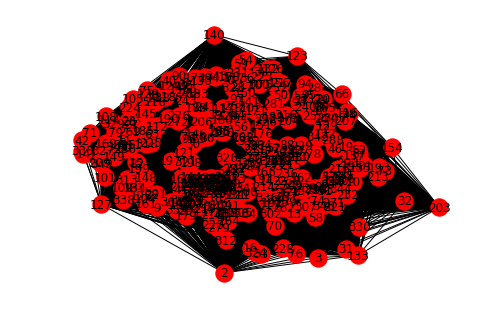

In [16]:
layout = nx.spring_layout(gDoc, k = .05, weight='weight', iterations= 50)
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()}) #Getting labels is a bit annoying

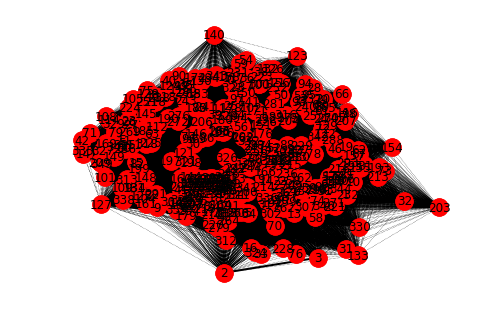

In [17]:

wMedian = np.median([d['weight'] for n1, n2, d in gDoc.edges(data = True)])
edgesHigh = [(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] > wMedian]
edgesLow = [(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] <= wMedian]
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()}, edgelist = edgesLow, style='dotted', width=.5)
nx.draw(gDoc, pos = layout, nodelist=None, edgelist = edgesHigh, width=2)

In [190]:
gWord = contractNetwork(g_2mode, 'word')
print(nx.info(gWord))

Name: 
Type: Graph
Number of nodes: 5887
Number of edges: 2665310
Average degree: 905.4901


In [19]:
wMean = np.mean([d['weight'] for n1, n2, d in gWord.edges(data = True)])
wMean

2.0165698315752785

In [191]:
gWord.remove_edges_from([(n1, n2) for n1, n2, d in gWord.edges(data = True) if d['weight'] <= 1])
gWord.remove_nodes_from(list(nx.isolates(gWord))) #since we are changing the graph list() evuluates the isolates first
print(nx.info(gWord))

Name: 
Type: Graph
Number of nodes: 3571
Number of edges: 968635
Average degree: 542.5007


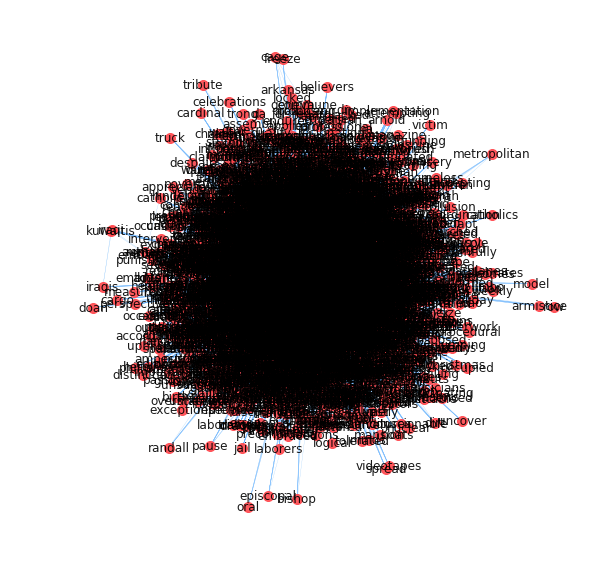

In [21]:
layout = nx.spring_layout(gWord, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(gWord, ax = ax, pos = layout, labels = {n:n for n in gWord.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

In [192]:
minWeight = 20
gWord.remove_edges_from([(n1, n2) for n1, n2, d in gWord.edges(data = True) if d['weight'] <= minWeight])
gWord.remove_nodes_from(list(nx.isolates(gWord))) #since we are changing the graph list() evuluates the isolates first
print(nx.info(gWord))

Name: 
Type: Graph
Number of nodes: 700
Number of edges: 42228
Average degree: 120.6514


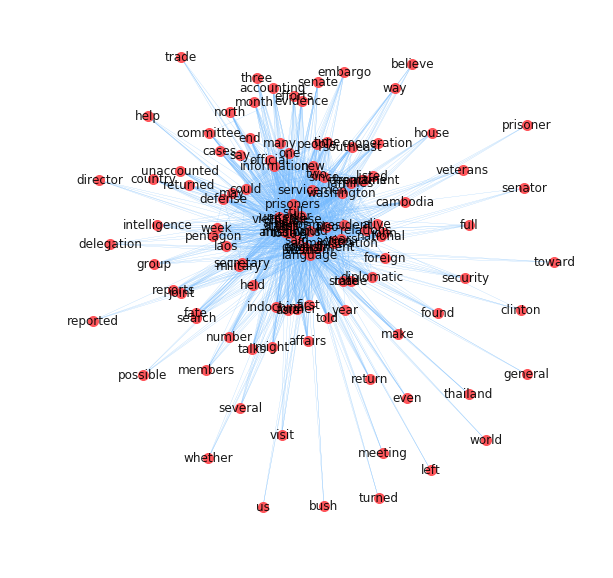

In [23]:
layout = nx.spring_layout(gWord, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(gWord, ax = ax, pos = layout, labels = {n:n for n in gWord.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

In [24]:
# betweeness
centralities = nx.betweenness.betweenness_centrality(gWord)


In [25]:
#centralities['vietnam']

In [28]:
max(centralities.items(), key = lambda x : x[1])

('english', 0.12054914018416048)

In [29]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[:10]


[('english', 0.12054914018416048),
 ('language', 0.12054914018416048),
 ('vietnam', 0.12054914018416048),
 ('missing', 0.05698051804623875),
 ('war', 0.04889444118221853),
 ('american', 0.04579575149634555),
 ('said', 0.045227387616777213),
 ('americans', 0.035728235802898405),
 ('united', 0.023193474954900876),
 ('vietnamese', 0.021253045711260687)]

In [30]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[50:60]


[('affairs', 0.0),
 ('alive', 0.0),
 ('believe', 0.0),
 ('bush', 0.0),
 ('cambodia', 0.0),
 ('cases', 0.0),
 ('clinton', 0.0),
 ('cooperation', 0.0),
 ('country', 0.0),
 ('delegation', 0.0)]

In [31]:
# degree
centralities = nx.degree_centrality(gWord)


In [32]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('english', 1.0),
 ('language', 1.0),
 ('vietnam', 1.0),
 ('missing', 0.8852459016393444),
 ('war', 0.8606557377049181),
 ('american', 0.8524590163934427),
 ('said', 0.8360655737704918),
 ('americans', 0.8114754098360656),
 ('united', 0.7459016393442623),
 ('vietnamese', 0.7377049180327869)]

In [33]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[-10:]

[('thailand', 0.03278688524590164),
 ('whether', 0.03278688524590164),
 ('bush', 0.02459016393442623),
 ('general', 0.02459016393442623),
 ('left', 0.02459016393442623),
 ('prisoner', 0.02459016393442623),
 ('toward', 0.02459016393442623),
 ('turned', 0.02459016393442623),
 ('us', 0.02459016393442623),
 ('world', 0.02459016393442623)]

In [34]:
# closeness! useful!

centralities = nx.closeness_centrality(gWord)

In [35]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('english', 1.0),
 ('language', 1.0),
 ('vietnam', 1.0),
 ('missing', 0.8970588235294118),
 ('war', 0.8776978417266187),
 ('american', 0.8714285714285714),
 ('said', 0.8591549295774648),
 ('americans', 0.8413793103448276),
 ('united', 0.7973856209150327),
 ('vietnamese', 0.7922077922077922)]

In [36]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[-10:]

[('thailand', 0.5083333333333333),
 ('whether', 0.5083333333333333),
 ('bush', 0.5062240663900415),
 ('general', 0.5062240663900415),
 ('left', 0.5062240663900415),
 ('prisoner', 0.5062240663900415),
 ('toward', 0.5062240663900415),
 ('turned', 0.5062240663900415),
 ('us', 0.5062240663900415),
 ('world', 0.5062240663900415)]

# pow80

In [193]:
g = wordCooccurrence(pow80['normalized_sents'].sum())

In [194]:
powVectorizer = sklearn.feature_extraction.text.CountVectorizer(tokenizer = tokenize)

# let's see what happens when I take the range [:10] our of vects_incidence
# this is apparently a bad idea...

powVects_incidence = powVectorizer.fit_transform(pow80['article'])

In [195]:
powVects_incidence.shape

(58, 2139)

In [196]:
g_2mode = nx.Graph()

#define all the nodes
g_2mode.add_nodes_from((powVectorizer.get_feature_names()[i] for i in range(powVects_incidence.shape[1])), bipartite = 'word')
g_2mode.add_nodes_from(range(powVects_incidence.shape[0]), bipartite = 'doc')

#add all the edges
g_2mode.add_edges_from(((d, powVectorizer.get_feature_names()[w], {'weight' : powVects_incidence[d, w]}) for d, w in zip(*powVects_incidence.nonzero())))

In [42]:
# crazy big
#nx.draw_networkx(g_2mode)

In [197]:
def contractNetwork(g, targetType):
    g_mono = nx.Graph()
    g_mono.add_nodes_from(((n, d) for n, d in g_2mode.nodes(data = True) if d['bipartite'] == targetType))
    
    for n_outside in (n for n, d in g_2mode.nodes(data = True) if d['bipartite'] != targetType):
        neighbors = list((n for n in g.neighbors(n_outside) if g.nodes[n]['bipartite'] == targetType))
        for i, n1 in enumerate(neighbors):
            for n2 in neighbors[i+1:]:
                try:
                    g_mono.edges[n1, n2]['weight'] += 1
                except KeyError:
                    g_mono.add_edge(n1, n2, weight = 1)
    return g_mono

In [198]:
gDoc = contractNetwork(g_2mode, 'doc')

In [45]:
print(nx.info(gDoc))

Name: 
Type: Graph
Number of nodes: 58
Number of edges: 1653
Average degree:  57.0000


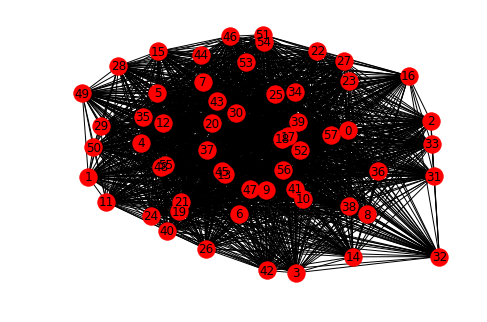

In [46]:
layout = nx.spring_layout(gDoc, k = .13, weight='weight', iterations= 50)
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()}) #Getting labels is a bit annoying

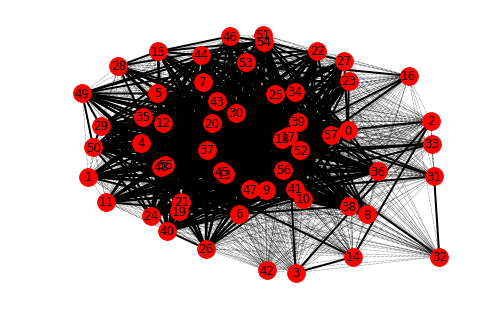

In [47]:
wMedian = np.median([d['weight'] for n1, n2, d in gDoc.edges(data = True)])
edgesHigh = [(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] > wMedian]
edgesLow = [(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] <= wMedian]
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()}, edgelist = edgesLow, style='dotted', width=.5)
nx.draw(gDoc, pos = layout, nodelist=None, edgelist = edgesHigh, width=2)

In [108]:
# saves last plt call
plt.savefig('nyt80net.pdf')

In [111]:
print(pow80.iloc[32]['date'].strip().replace('  ', '\n'))
print(pow80.iloc[32]['article'].strip().replace('  ', '\n'))

June 12 1982
A correction yesterday, referring to a dispatch from Hanoi published on May 30 about missing American serv- icemen, incorrectly gave one name. It is Fredric Woodrow Knapp.
LANGUAGE: ENGLISH
TYPE: Correction


In [114]:
print(pow80.iloc[56]['date'].strip().replace('  ', '\n'))
print(pow80.iloc[56]['article'].strip().replace('  ', '\n'))

July 20 1984
President Reagan said today that Laos had agreed to allow United States officials to excavate a site to search for the remains of 13 American servicemen whose plane crashed there nearly 12 years ago.
Mr. Reagan made the disclosure during a ceremony at the White House in honor of National P.O.W./M.I.A. Recognition Day. At the ceremony, the President said the Administration was determined to recover the remains and press for information on 2,489 Americans unaccounted for from the Vietnam War, as well as 8,177 from the Korean War.
About 600 of the 2,489 were reported dead or missing in Laos. The Vientiane Government met with American officials last year and allowed a technical team to visit the crash site, near the city of Pakse.

Maintained Diplomatic Ties
The United States, which severed diplomatic relations with Vietnam and Cambodia after the Communist takeovers there in 1975, has maintained diplomatic relations with Laos, but has said ties could not be improved until the 

In [50]:
print(pow80.iloc[45]['date'].strip().replace('  ', '\n'))
print(pow80.iloc[45]['article'].strip().replace('  ', '\n'))

May 16 1983
The United States and the Communist Government of Laos, after years of tense relations, have quietly begun discussions aimed at upgrading their diplomatic missions and gaining closer ties, Administration officials said today.
In recent months, they said, Laos has sent several significant signals to the Reagan Administration that State Department and White House officials view as opening the way to firmer links between Vientiane and Washington. These include welcoming and assisting an American group searching for information on United States servicemen missing in action since the Indochina war, as well as affording American diplomats access to Laotian Government officials for the first time in years.
''They want to move forward,'' an Administration official said.
Another official remarked, ''They appear more flexible, more sensitive.''
S.I. Hayakawa, the former Republican Senator from California who was chairman of the East Asian and Pacific Affairs Subcommittee of the Senat

In [199]:
gWord = contractNetwork(g_2mode, 'word')

In [200]:
wMean = np.mean([d['weight'] for n1, n2, d in gWord.edges(data = True)])
wMean

1.4311602708803612

In [201]:
gWord.remove_edges_from([(n1, n2) for n1, n2, d in gWord.edges(data = True) if d['weight'] <= 1])
gWord.remove_nodes_from(list(nx.isolates(gWord))) #since we are changing the graph list() evuluates the isolates first
print(nx.info(gWord))

Name: 
Type: Graph
Number of nodes: 1026
Number of edges: 88487
Average degree: 172.4893


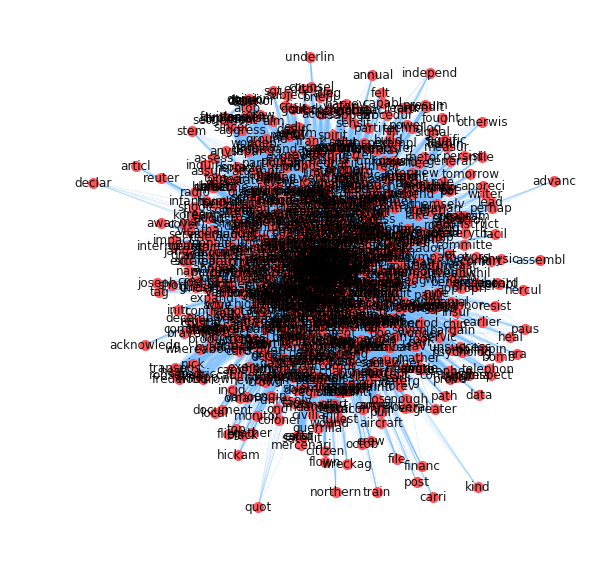

In [202]:
layout = nx.spring_layout(gWord, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(gWord, ax = ax, pos = layout, labels = {n:n for n in gWord.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

In [205]:
minWeight = 15
gWord.remove_edges_from([(n1, n2) for n1, n2, d in gWord.edges(data = True) if d['weight'] <= minWeight])
gWord.remove_nodes_from(list(nx.isolates(gWord))) #since we are changing the graph list() evuluates the isolates first
print(nx.info(gWord))

Name: 
Type: Graph
Number of nodes: 69
Number of edges: 591
Average degree:  17.1304


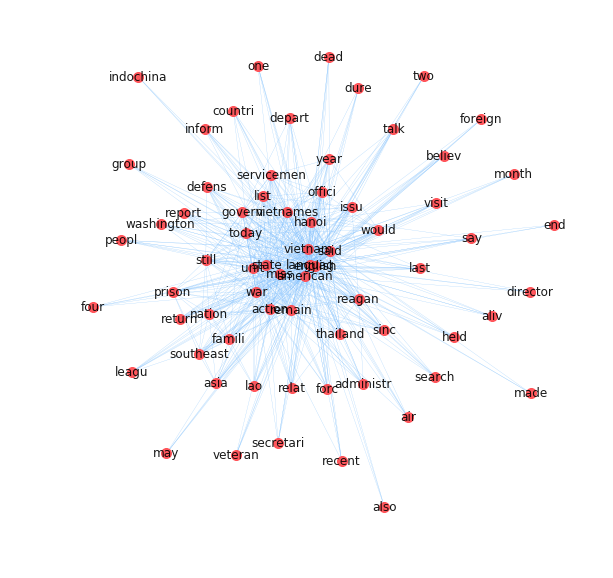

In [206]:
layout = nx.spring_layout(gWord, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(gWord, ax = ax, pos = layout, labels = {n:n for n in gWord.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

In [207]:
# betweeness
centralities = nx.betweenness.betweenness_centrality(gWord)
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[3:13]


[('american', 0.1143729704451183),
 ('said', 0.06496385356453528),
 ('miss', 0.04597337179969003),
 ('war', 0.020177630617645086),
 ('state', 0.019689176529542173),
 ('unit', 0.016691903097677),
 ('vietnames', 0.011430200601558343),
 ('remain', 0.010201036389514412),
 ('action', 0.0068072494136378866),
 ('hanoi', 0.005116488218925857)]

In [58]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[:10]


[('english', 1.0),
 ('language', 1.0),
 ('vietnam', 0.98),
 ('americans', 0.9074074074074074),
 ('american', 0.8990825688073395),
 ('missing', 0.8448275862068966),
 ('said', 0.8448275862068966),
 ('war', 0.8099173553719008),
 ('united', 0.7777777777777778),
 ('vietnamese', 0.7596899224806202)]

In [59]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[50:60]


[('one', 0.547486033519553),
 ('returned', 0.547486033519553),
 ('four', 0.5444444444444444),
 ('intelligence', 0.5444444444444444),
 ('dead', 0.5414364640883977),
 ('may', 0.5414364640883977),
 ('foreign', 0.5384615384615384),
 ('indochina', 0.5384615384615384),
 ('official', 0.5384615384615384),
 ('three', 0.5355191256830601)]

In [60]:
# degree
centralities = nx.degree_centrality(gWord)


In [61]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('english', 0.9999999999999999),
 ('language', 0.9999999999999999),
 ('vietnam', 0.9795918367346939),
 ('americans', 0.8979591836734693),
 ('american', 0.8877551020408162),
 ('missing', 0.8163265306122448),
 ('said', 0.8163265306122448),
 ('war', 0.7653061224489796),
 ('united', 0.7142857142857142),
 ('vietnamese', 0.6836734693877551)]

In [62]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[-10:]

[('assistant', 0.0510204081632653),
 ('meeting', 0.0510204081632653),
 ('number', 0.0510204081632653),
 ('bodies', 0.04081632653061224),
 ('week', 0.04081632653061224),
 ('year', 0.04081632653061224),
 ('countries', 0.030612244897959183),
 ('end', 0.030612244897959183),
 ('recent', 0.030612244897959183),
 ('turned', 0.030612244897959183)]

In [208]:
# closeness! useful!

centralities = nx.closeness_centrality(gWord)

In [209]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[3:13]

[('american', 0.9315068493150684),
 ('said', 0.8192771084337349),
 ('miss', 0.7816091954022989),
 ('state', 0.7157894736842105),
 ('war', 0.7083333333333334),
 ('unit', 0.7010309278350515),
 ('remain', 0.6732673267326733),
 ('vietnames', 0.6666666666666666),
 ('action', 0.6601941747572816),
 ('hanoi', 0.6296296296296297)]

In [210]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[-10:]

[('veteran', 0.5190839694656488),
 ('director', 0.5151515151515151),
 ('foreign', 0.5151515151515151),
 ('may', 0.5151515151515151),
 ('month', 0.5151515151515151),
 ('two', 0.5151515151515151),
 ('also', 0.5112781954887218),
 ('end', 0.5112781954887218),
 ('indochina', 0.5112781954887218),
 ('made', 0.5112781954887218)]

# pow85

In [211]:
g = wordCooccurrence(pow85['normalized_sents'].sum())

In [212]:
powVectorizer = sklearn.feature_extraction.text.CountVectorizer(tokenizer = tokenize)

# let's see what happens when I take the range [:10] our of vects_incidence
# this is apparently a bad idea...

powVects_incidence = powVectorizer.fit_transform(pow85['article'])

In [144]:
powVects_incidence.shape

(93, 3487)

In [213]:
g_2mode = nx.Graph()

#define all the nodes
g_2mode.add_nodes_from((powVectorizer.get_feature_names()[i] for i in range(powVects_incidence.shape[1])), bipartite = 'word')
g_2mode.add_nodes_from(range(powVects_incidence.shape[0]), bipartite = 'doc')

#add all the edges
g_2mode.add_edges_from(((d, powVectorizer.get_feature_names()[w], {'weight' : powVects_incidence[d, w]}) for d, w in zip(*powVects_incidence.nonzero())))

In [214]:
def contractNetwork(g, targetType):
    g_mono = nx.Graph()
    g_mono.add_nodes_from(((n, d) for n, d in g_2mode.nodes(data = True) if d['bipartite'] == targetType))
    
    for n_outside in (n for n, d in g_2mode.nodes(data = True) if d['bipartite'] != targetType):
        neighbors = list((n for n in g.neighbors(n_outside) if g.nodes[n]['bipartite'] == targetType))
        for i, n1 in enumerate(neighbors):
            for n2 in neighbors[i+1:]:
                try:
                    g_mono.edges[n1, n2]['weight'] += 1
                except KeyError:
                    g_mono.add_edge(n1, n2, weight = 1)
    return g_mono

In [215]:
gDoc = contractNetwork(g_2mode, 'doc')

In [216]:
print(nx.info(gDoc))

Name: 
Type: Graph
Number of nodes: 93
Number of edges: 4278
Average degree:  92.0000


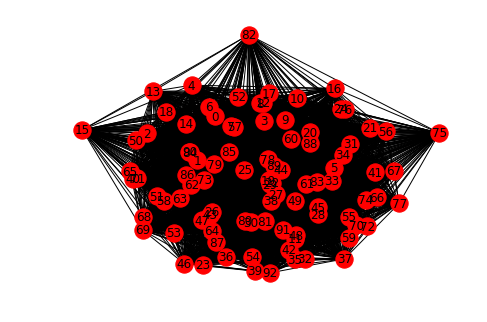

In [73]:
layout = nx.spring_layout(gDoc, k = .1, weight='weight', iterations= 50)
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()}) #Getting labels is a bit annoying

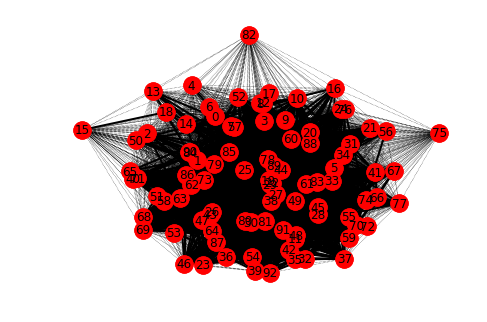

In [74]:
wMedian = np.median([d['weight'] for n1, n2, d in gDoc.edges(data = True)])
edgesHigh = [(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] > wMedian]
edgesLow = [(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] <= wMedian]
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()}, edgelist = edgesLow, style='dotted', width=.5)
nx.draw(gDoc, pos = layout, nodelist=None, edgelist = edgesHigh, width=2)

In [116]:
print(pow85.iloc[82]['date'].strip().replace('  ', '\n'))
print(pow85.iloc[82]['article'].strip().replace('  ', '\n'))

August 1 1987
Gen. John W. Vessey Jr. is meeting with Vietnamese officials on missing Americans. (U.S. Army) Page 5.
LANGUAGE: ENGLISH
TYPE: CAPTION


In [118]:
print(pow85.iloc[38]['date'].strip().replace('  ', '\n'))
print(pow85.iloc[38]['article'].strip().replace('  ', '\n'))

September 3 1985
The Reagan Administration said today that talks last week with Vietnamese officials in Hanoi were ''the most positive'' to date in the 12-year effort to resolve the problem of Americans unaccounted for in the Vietnam War.
A State Department spokesman, Charles E. Redman, said that ''I am pleased to state that the talks were very productive'' and that the meeting ''took place in a constructive atmosphere.''
Last Wednesday and Thursday, a four-member United States team led by Richard Childress, the political and military affairs director of the National Security Council staff, met with the acting Vietnamese Foreign Minister, Vo Dong Giang, and with Deputy Foreign Minister Hoang Bich Son.
Originally, a higher-level American delegation, led by Richard L. Armitage, Assistant Secretary of Defense, and Paul D. Wolfowitz, Assistant Secretary of State for East Asian and Pacific Affairs, had been scheduled to meet with Foreign Minister Nguyen Co Thach. But when Mr. Thach informed

In [77]:
print(pow85.iloc[70]['date'].strip().replace('  ', '\n'))
print(pow85.iloc[70]['article'].strip().replace('  ', '\n'))

August 16 1986
, Thailand, Aug. 16
 American experts trying to account for Americans reported missing in the Vietnam War investigated sites in Hanoi last week containing wreckage of B-52 bombers, the leader of the United States team said on his return here today.
The official, Lieut. Col. Joe Harvey, commander of the United States Joint Casualty Resolution Center in Honolulu, said the Vietnamese provided new information on missing Americans and a report of their continuing investigations during three days of talks in Hanoi. He declined to elaborate.
Colonel Harvey refused to say whether Vietnam would soon repatriate remains of some of the nearly 1,800 American troops and civilians listed as missing from the war.
He said the United States team handed over new information on cases of missing Americans and on reports that Americans have been seen in Vietnam since the war.
LANGUAGE: ENGLISH


In [217]:
gWord = contractNetwork(g_2mode, 'word')

In [218]:
wMean = np.mean([d['weight'] for n1, n2, d in gWord.edges(data = True)])
wMean

1.6543731034455473

In [219]:
gWord.remove_edges_from([(n1, n2) for n1, n2, d in gWord.edges(data = True) if d['weight'] <= 1])
gWord.remove_nodes_from(list(nx.isolates(gWord))) #since we are changing the graph list() evuluates the isolates first
print(nx.info(gWord))

Name: 
Type: Graph
Number of nodes: 1324
Number of edges: 184281
Average degree: 278.3701


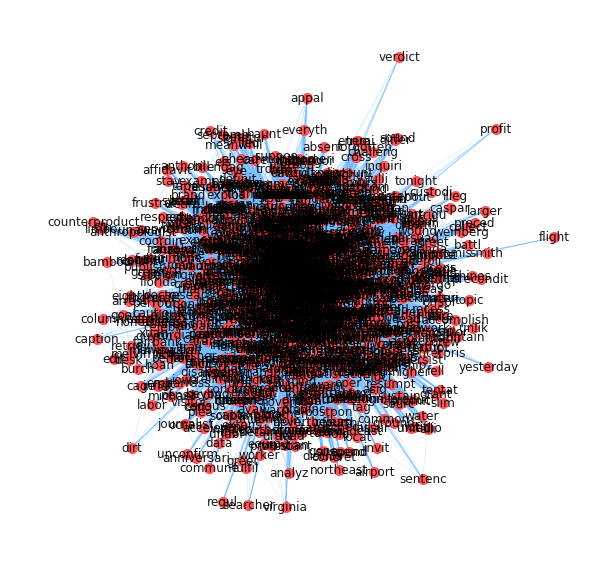

In [220]:
layout = nx.spring_layout(gWord, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(gWord, ax = ax, pos = layout, labels = {n:n for n in gWord.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

In [226]:
minWeight = 30
gWord.remove_edges_from([(n1, n2) for n1, n2, d in gWord.edges(data = True) if d['weight'] <= minWeight])
gWord.remove_nodes_from(list(nx.isolates(gWord))) #since we are changing the graph list() evuluates the isolates first
print(nx.info(gWord))

Name: 
Type: Graph
Number of nodes: 44
Number of edges: 433
Average degree:  19.6818


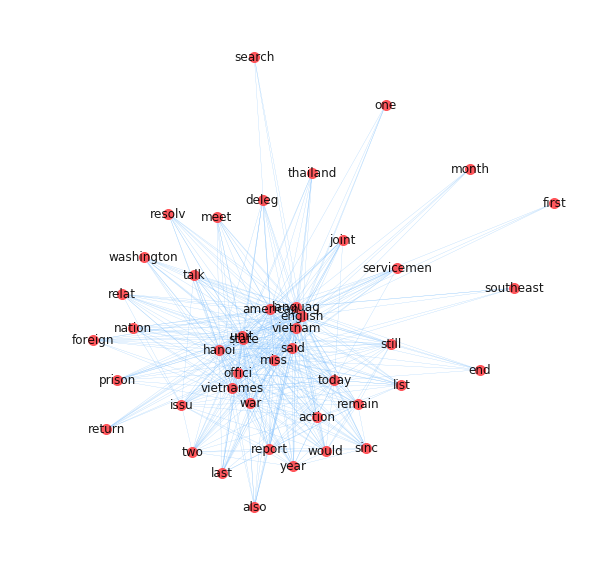

In [227]:
layout = nx.spring_layout(gWord, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(gWord, ax = ax, pos = layout, labels = {n:n for n in gWord.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

In [228]:
# betweeness
centralities = nx.betweenness.betweenness_centrality(gWord)
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[:10]


[('english', 0.09410315010520211),
 ('languag', 0.09410315010520211),
 ('vietnam', 0.07014597033406883),
 ('american', 0.06798650189553061),
 ('said', 0.05395918554263286),
 ('miss', 0.043900123157989086),
 ('state', 0.03133354613958483),
 ('unit', 0.03133354613958483),
 ('hanoi', 0.02344318069107985),
 ('vietnames', 0.020248043110560207)]

In [85]:
# degree
centralities = nx.degree_centrality(gWord)
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[:10]


[('english', 1.0),
 ('language', 1.0),
 ('vietnam', 0.9610389610389611),
 ('missing', 0.9350649350649352),
 ('said', 0.9350649350649352),
 ('americans', 0.8961038961038962),
 ('american', 0.8831168831168832),
 ('states', 0.8571428571428572),
 ('united', 0.8571428571428572),
 ('vietnamese', 0.8051948051948052)]

In [229]:
# closeness centrality
centralities = nx.closeness_centrality(gWord)
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[3:13]

[('vietnam', 0.9555555555555556),
 ('said', 0.9347826086956522),
 ('miss', 0.9148936170212766),
 ('state', 0.8775510204081632),
 ('unit', 0.8775510204081632),
 ('hanoi', 0.8431372549019608),
 ('vietnames', 0.8113207547169812),
 ('offici', 0.7962962962962963),
 ('war', 0.7678571428571429),
 ('today', 0.7166666666666667)]

# pow90

In [155]:
g = wordCooccurrence(pow90['normalized_sents'].sum())

In [156]:
powVectorizer = sklearn.feature_extraction.text.CountVectorizer(tokenizer = tokenize)

# let's see what happens when I take the range [:10] our of vects_incidence
# this is apparently a bad idea...

powVects_incidence = powVectorizer.fit_transform(pow90['article'])

In [158]:
powVects_incidence.shape

(205, 7694)

In [159]:
g_2mode = nx.Graph()

#define all the nodes
g_2mode.add_nodes_from((powVectorizer.get_feature_names()[i] for i in range(powVects_incidence.shape[1])), bipartite = 'word')
g_2mode.add_nodes_from(range(powVects_incidence.shape[0]), bipartite = 'doc')

#add all the edges
g_2mode.add_edges_from(((d, powVectorizer.get_feature_names()[w], {'weight' : powVects_incidence[d, w]}) for d, w in zip(*powVects_incidence.nonzero())))

In [160]:
def contractNetwork(g, targetType):
    g_mono = nx.Graph()
    g_mono.add_nodes_from(((n, d) for n, d in g_2mode.nodes(data = True) if d['bipartite'] == targetType))
    
    for n_outside in (n for n, d in g_2mode.nodes(data = True) if d['bipartite'] != targetType):
        neighbors = list((n for n in g.neighbors(n_outside) if g.nodes[n]['bipartite'] == targetType))
        for i, n1 in enumerate(neighbors):
            for n2 in neighbors[i+1:]:
                try:
                    g_mono.edges[n1, n2]['weight'] += 1
                except KeyError:
                    g_mono.add_edge(n1, n2, weight = 1)
    return g_mono

In [161]:
gDoc = contractNetwork(g_2mode, 'doc')

In [162]:
print(nx.info(gDoc))

Name: 
Type: Graph
Number of nodes: 205
Number of edges: 20910
Average degree: 204.0000


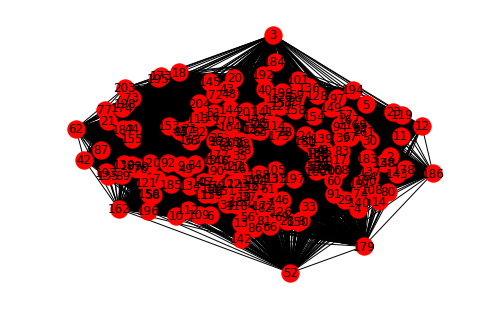

In [94]:
#re-run

layout = nx.spring_layout(gDoc, k = .07, weight='weight', iterations= 50)
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()}) #Getting labels is a bit annoying

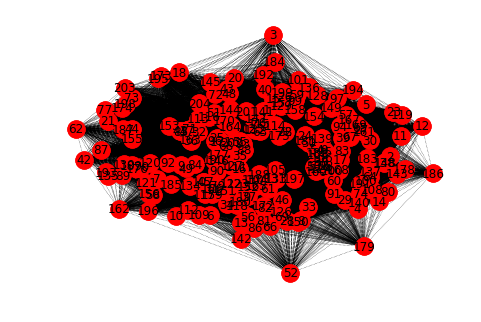

In [95]:
wMedian = np.median([d['weight'] for n1, n2, d in gDoc.edges(data = True)])
edgesHigh = [(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] > wMedian]
edgesLow = [(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] <= wMedian]
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()}, edgelist = edgesLow, style='dotted', width=.5)
nx.draw(gDoc, pos = layout, nodelist=None, edgelist = edgesHigh, width=2)

In [121]:
print(pow90.iloc[175]['date'].strip().replace('  ', '\n'))
print(pow90.iloc[175]['article'].strip().replace('  ', '\n'))

May 19 1994
, Vietnam
 "For 2,000 years, wars have seeded our land with the bones of the missing in action," the general told a visitor, "and the American war produced a particularly rich crop. We'll never find most of our own dead soldiers, but they remain in our hearts."
The speaker, Maj. Gen. Nguyen Trong Vinh, spent most of his 68 years fighting the French and the Americans, and he now publishes a monthly magazine for North Vietnamese and Vietcong veterans listing grave sites and missing soldiers and guerrillas.
Sometimes families who see the photographs, eyewitness reports and maps that the magazine publishes have been able to identify the resting places of missing husbands, fathers and sons.
The quest by the United States for its war dead and missing in Vietnam seems to have brought increased efforts by Hanoi to account for Communist troops who remain missing.
Besides offering information that might help identify Communist dead, ordinary Vietnamese also sometimes respond to an Am

In [110]:
print(pow90.iloc[3]['date'].strip().replace('  ', '\n'))
print(pow90.iloc[3]['article'].strip().replace('  ', '\n'))

December 13 1990
The remains of two American servicemen who had been listed as missing in action in Vietnam have been identified, the Pentagon said Wednesday.
The remains, identified as those of Lieut. Col. William R. Andrews of the Air Force and Lieut. Comdr. Frederick W. Wright 3d of the Navy, were repatriated by Vietnam in September.
LOAD-DATE: December 14, 1990
LANGUAGE: ENGLISH


In [163]:
gWord = contractNetwork(g_2mode, 'word')

In [99]:
wMean = np.mean([d['weight'] for n1, n2, d in gWord.edges(data = True)])
wMean

1.8830305693235414

In [164]:
gWord.remove_edges_from([(n1, n2) for n1, n2, d in gWord.edges(data = True) if d['weight'] <= 1])
gWord.remove_nodes_from(list(nx.isolates(gWord))) #since we are changing the graph list() evuluates the isolates first
print(nx.info(gWord))

Name: 
Type: Graph
Number of nodes: 4149
Number of edges: 905059
Average degree: 436.2781


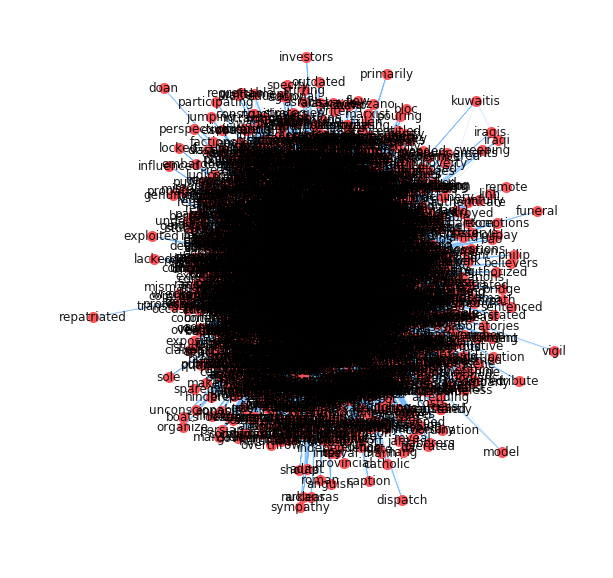

In [165]:
layout = nx.spring_layout(gWord, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(gWord, ax = ax, pos = layout, labels = {n:n for n in gWord.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

In [180]:
minWeight = 80
gWord.remove_edges_from([(n1, n2) for n1, n2, d in gWord.edges(data = True) if d['weight'] <= minWeight])
gWord.remove_nodes_from(list(nx.isolates(gWord))) #since we are changing the graph list() evuluates the isolates first
print(nx.info(gWord))

Name: 
Type: Graph
Number of nodes: 55
Number of edges: 498
Average degree:  18.1091


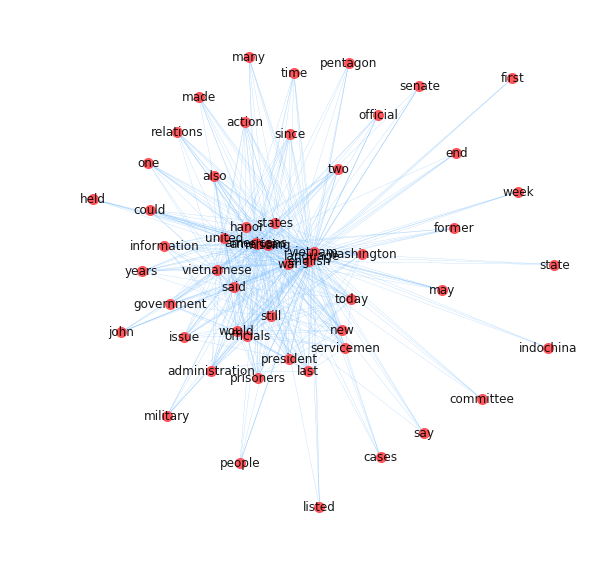

In [181]:
layout = nx.spring_layout(gWord, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(gWord, ax = ax, pos = layout, labels = {n:n for n in gWord.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

In [169]:
# betweeness
centralities = nx.betweenness.betweenness_centrality(gWord)
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[:10]


[('english', 0.1010686832525723),
 ('language', 0.1010686832525723),
 ('vietnam', 0.08786736312055911),
 ('war', 0.06161032565210636),
 ('american', 0.04976796494544751),
 ('missing', 0.04544841534342848),
 ('said', 0.03392730524922579),
 ('americans', 0.03343040681988706),
 ('vietnamese', 0.027229975852420558),
 ('hanoi', 0.02543553170212318)]

In [170]:


# degree
centralities = nx.degree_centrality(gWord)
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[:10]


[('english', 1.0),
 ('language', 1.0),
 ('vietnam', 0.9803921568627451),
 ('war', 0.9313725490196079),
 ('american', 0.9117647058823529),
 ('missing', 0.9019607843137255),
 ('americans', 0.8627450980392157),
 ('said', 0.8627450980392157),
 ('vietnamese', 0.8235294117647058),
 ('hanoi', 0.8137254901960784)]

In [230]:
# closeness! useful!

centralities = nx.closeness_centrality(gWord)
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[1:10]

[('languag', 1.0),
 ('american', 0.9555555555555556),
 ('vietnam', 0.9555555555555556),
 ('said', 0.9347826086956522),
 ('miss', 0.9148936170212766),
 ('state', 0.8775510204081632),
 ('unit', 0.8775510204081632),
 ('hanoi', 0.8431372549019608),
 ('vietnames', 0.8113207547169812)]

In [231]:
centralities = nx.eigenvector_centrality(gWord)
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[1:10]


[('languag', 0.23043366908077342),
 ('american', 0.2280007992013503),
 ('vietnam', 0.227657631899825),
 ('said', 0.226954372744196),
 ('miss', 0.22556582159342467),
 ('state', 0.22144367064672432),
 ('unit', 0.22144367064672432),
 ('hanoi', 0.21594718119709408),
 ('vietnames', 0.2073230983424107)]